In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import physutils as phys
import dbio
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

plt.style.use('ggplot')

# Prepare data from scratch, or just run prepped data?

Extracting and preparing the spike data for the glm can take a while. Set the following variable to True to perform that process:

In [2]:
reprep_data = False

# Basic properties

Let's get some basic statistics about our population of neurons:

In [3]:
# open data file
dbname = os.path.expanduser('data/bart.hdf5')

# get list of all patient, dataset pairs corresponding to behavior
evtlist = pd.read_hdf(dbname, '/meta/evlist')

# get list of all units
spklist = pd.read_hdf(dbname, '/meta/spklist')

# remove subject 10, who did a previous version of the task
# evtlist = evtlist.query('patient != 10')
# spklist = spklist.query('patient != 10')

How many units do we have?

In [4]:
print "Number of units: {}".format(spklist.shape[0])

Number of units: 56


## Make a histogram of firing rates

In [5]:
# for each unit, take mean firing rate as the number of spikes divided by the last time stamp
# this is only a crude measure and ignores censoring
allfr = pd.DataFrame()
for _, dtup in spklist.iterrows():
    dtup = tuple(dtup)
    spks = dbio.fetch(dbname, 'spikes', *dtup)
    this_fr = spks[-1:].copy()
    this_fr['rate'] = spks.shape[0] / this_fr['time']
    allfr = allfr.append(this_fr)

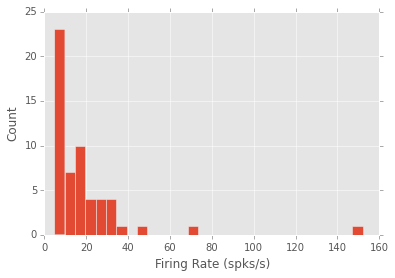

In [6]:
# make plot
allfr.rate.plot(kind='hist', bins=30);
plt.xlabel('Firing Rate (spks/s)');
plt.ylabel('Count');


## Run a GLM

Load and prep our spiking data for use with R's glmnet package:

In [7]:
if reprep_data:
    %run prep_spike_data

Call an R script to fit the model and perform cross-validation (note that it matters whether this is done with $\lambda_{\mathrm{min}}$ or $\lambda_{\mathrm{1se}}$; default is currently the latter):

In [8]:
!Rscript perform_glm_analysis.R spikes

[1] "Performing spike analysis..."
[1] "data/10.1.1.1.spkglmdata.csv"
[1] "data/11.1.1.1.spkglmdata.csv"
[1] "data/12.1.1.1.spkglmdata.csv"
[1] "data/14.1.1.1.spkglmdata.csv"
[1] "data/14.2.1.1.spkglmdata.csv"
[1] "data/15.1.1.1.spkglmdata.csv"
[1] "data/17.1.1.1.spkglmdata.csv"
[1] "data/17.2.1.1.spkglmdata.csv"
[1] "data/17.2.2.1.spkglmdata.csv"
[1] "data/17.2.3.1.spkglmdata.csv"
[1] "data/17.2.5.1.spkglmdata.csv"
[1] "data/17.2.7.1.spkglmdata.csv"
[1] "data/17.2.8.1.spkglmdata.csv"
[1] "data/17.2.10.1.spkglmdata.csv"
[1] "data/17.2.11.1.spkglmdata.csv"
[1] "data/18.1.1.1.spkglmdata.csv"
[1] "data/18.1.1.2.spkglmdata.csv"
[1] "data/18.1.13.1.spkglmdata.csv"
[1] "data/18.1.15.1.spkglmdata.csv"
[1] "data/20.1.1.1.spkglmdata.csv"
[1] "data/20.1.1.2.spkglmdata.csv"
[1] "data/20.1.2.1.spkglmdata.csv"
[1] "data/20.1.2.2.spkglmdata.csv"
[1] "data/20.1.3.1.spkglmdata.csv"
[1] "data/20.1.3.2.spkglmdata.csv"
[1] "data/20.1.4.1.spkglmdata.csv"
[1] "data/20.1.4.2.spkglmdata.csv"
[1] "data/20.1.5

In [9]:
%load_ext rpy2.ipython

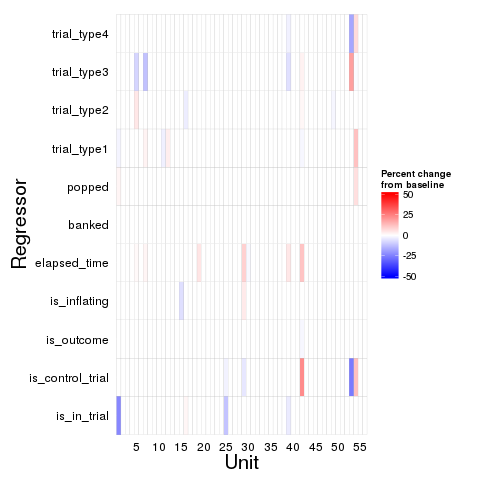

In [10]:
lambdatype = '1se'
%Rpush lambdatype
%R source("analyze_spike_glm_output.R");
%Rpull effects
effects = pd.DataFrame(effects)

In [11]:
effects.columns = ['Unit', 'In trial', 'Control Trial', 'Outcome period', 'Inflating', 'Elapsed time', 'Banked', 
                   'Popped', 'Low Risk', 'Medium Risk', 'High Risk', 'Unrewarded Trial']
effects = effects.set_index('Unit')
effects.head()

,In trial,Control Trial,Outcome period,Inflating,Elapsed time,Banked,Popped,Low Risk,Medium Risk,High Risk,Unrewarded Trial
Unit,,,,,,,,,,,
1,-23.473644,0,0,0,0.000000,0,1.887093,-1.91882,0.000000,0.000000,NaN
2,0.000000,0,0,0,0.000000,0,0.000000,0.00000,0.000000,0.000000,NaN
3,0.000000,0,0,0,0.000000,0,0.000000,0.00000,0.000000,0.000000,NaN
4,0.000000,0,0,0,0.000000,0,0.000000,0.00000,0.000000,0.000000,NaN
5,0.000000,0,0,0,0.997862,0,0.000000,0.00000,4.503377,-8.192494,NaN


In [12]:
# make a normalizer so we can set the colormap midpoint
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

eff_limit = 25  # percent change at which to saturate color scale
norm = MidpointNormalize(midpoint=0, vmin=-eff_limit, vmax=eff_limit)
cmap = plt.cm.RdBu_r
cmap.set_bad(color='k', alpha=1.0)

In [13]:
def plot_effects(effects, cmap, title):
    effmat = np.ma.array(effects, mask=np.isnan(effects))
    #plt.matshow(effmat.T, cmap=cmap, norm=norm, aspect=5);
    plt.pcolor(effmat.T, cmap=cmap, norm=norm);

    # set limits
    plt.xlim(0, effects.index.max())
    plt.ylim(0, len(effects.columns))

    # move xticks to bottom, flip y axis
    plt.gca().xaxis.tick_bottom()
    plt.gca().invert_yaxis()

    # set y labels
    plt.yticks(np.arange(len(effects.columns)) + 0.5, effects.columns)

    # label axes
    plt.xlabel('Unit')
    plt.ylabel('Effect')

    # title plot
    plt.title(title)
    
    # add colorbar
    plt.colorbar().set_label('% Change from baseline');

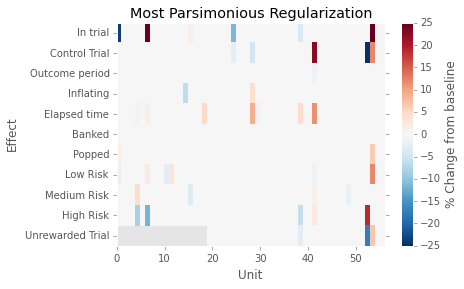

In [14]:
plot_effects(effects, cmap, 'Most Parsimonious Regularization')

### Make some summaries of GLM effects

#### Percentage of units with effects of each regressor

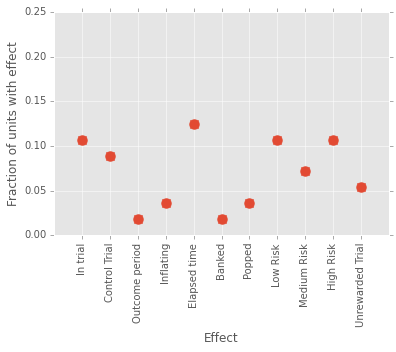

In [15]:
eff_present = ((effects != 0) & ~np.isnan(effects))
nregressors = eff_present.shape[1]
(eff_present.sum() / eff_present.count()).plot(linestyle='none', marker='.', markersize=20);
plt.xticks(xrange(nregressors), eff_present.columns, rotation='vertical');
plt.xlim(-1, nregressors);
plt.ylim(0, 0.25);
plt.xlabel('Effect');
plt.ylabel('Fraction of units with effect');

#### Number of regressors in the model for each unit

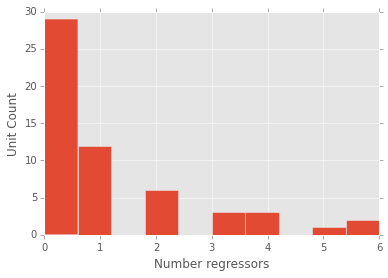

In [16]:
nunits = effects.shape[0]
eff_present = (effects != 0)
(eff_present.sum(axis=1)).plot(kind='hist', bins=10);
plt.ylabel('Unit Count');
plt.xlabel('Number regressors');

#### Mean absolute effect size (for units where a particular regressor is included)

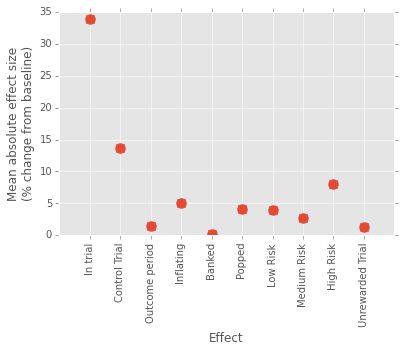

In [17]:
eff_df = effects.drop('Elapsed time', axis=1)
nregressors = eff_df.shape[1]
(eff_df.abs().sum() / (eff_df != 0).sum()).plot(linestyle='none', marker='.', markersize=20);
plt.xticks(xrange(nregressors), eff_df.columns, rotation='vertical');
plt.xlim(-1, nregressors);
plt.xlabel('Effect');
plt.ylabel('Mean absolute effect size \n(% change from baseline)');

#### Task-relatedness of neuron (mean of absolute values of coefficients in model)

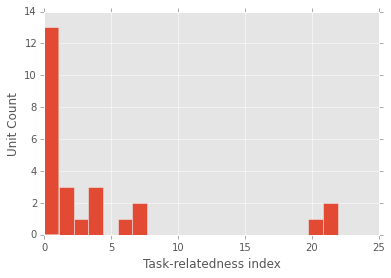

In [18]:
eff_df = effects.drop('Elapsed time', axis=1)
mean_abs_coeff = (eff_df.abs().sum(axis=1) / (eff_df !=0).sum(axis=1)).sort(inplace=False)
mean_abs_coeff = mean_abs_coeff[np.isfinite(mean_abs_coeff)]
mean_abs_coeff.plot(kind='hist', bins=20);
plt.xlabel('Task-relatedness index');
plt.ylabel('Unit Count');

#### Power-law behavior of elapsed time regressor

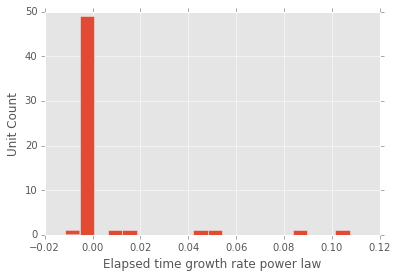

In [19]:
et_eff = effects['Elapsed time']
et_eff = np.log(et_eff/100 + 1)  # actual beta from the regression
et_eff.plot(kind='hist', bins=20);
plt.xlabel('Elapsed time growth rate power law');
plt.ylabel('Unit Count');

#### Number of units with elapsed time effect

In [20]:
et_eff = effects['Elapsed time']
num_et = (et_eff != 0).sum()
print "Number of units with elapsed time effect = {}".format(num_et)
print "Percent with elapsed time effect = {}".format(num_et / et_eff.count())

eff_powers = np.log(et_eff/100 + 1)  # actual beta from the regression
eff_powers = eff_powers[eff_powers != 0]
T = 5  # rough order of magnitude of inflate time (seconds)
eff_sizes = 100 * ((T + 1) ** eff_powers - 1)
print "effect sizes (percent change over {} seconds):\n".format(T), eff_sizes

Number of units with elapsed time effect = 7
Percent with elapsed time effect = 0.125
effect sizes (percent change over 5 seconds):
Unit
5      1.794987
7      3.278141
19     9.085345
29    16.819506
30    -1.995776
39     8.484560
42    21.235654
Name: Elapsed time, dtype: float64


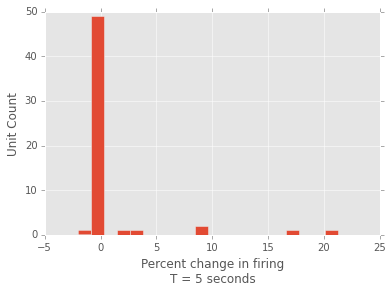

In [21]:
et_eff = effects['Elapsed time']
eff_powers = np.log(et_eff/100 + 1)  # actual beta from the regression
T = 5  # rough order of magnitude of inflate time (seconds)
eff_sizes = 100 * ((T + 1) ** eff_powers - 1)
eff_sizes.plot(kind='hist', bins=20);
plt.xlabel('Percent change in firing\nT = {} seconds'.format(T));
plt.ylabel('Unit Count');

## make some PSTHs

In [22]:
unit = 15
dtup = tuple(spklist.iloc[unit])
spks = dbio.load_spikes(dbname, dtup)
evt = dbio.fetch(dbname, 'events', *dtup[0:2])

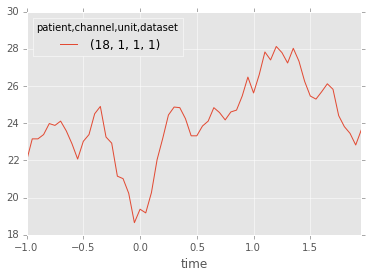

In [23]:
event = 'banked'
Tpre = -1
Tpost = 2
psth = phys.psth(spks, evt[event].dropna(), Tpre, Tpost)
phys.smooth(psth, 0.2).plot();

# Alternate GLM regularizations and controls

## GLM with best predictive regularization:

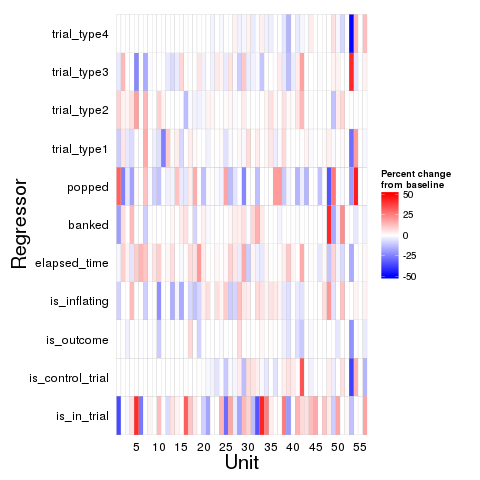

In [24]:
lambdatype = 'min'
%Rpush lambdatype
%R source("analyze_spike_glm_output.R");
%Rpull effects
effects = pd.DataFrame(effects)
effects.columns = ['Unit', 'In trial', 'Control Trial', 'Outcome period', 'Inflating', 'Elapsed time', 'Banked', 
                   'Popped', 'Low Risk', 'Medium Risk', 'High Risk', 'Unrewarded Trial']
effects = effects.set_index('Unit')

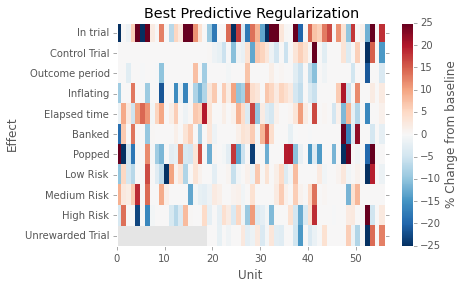

In [25]:
plot_effects(effects, cmap, 'Best Predictive Regularization')

## GLM with no regularization

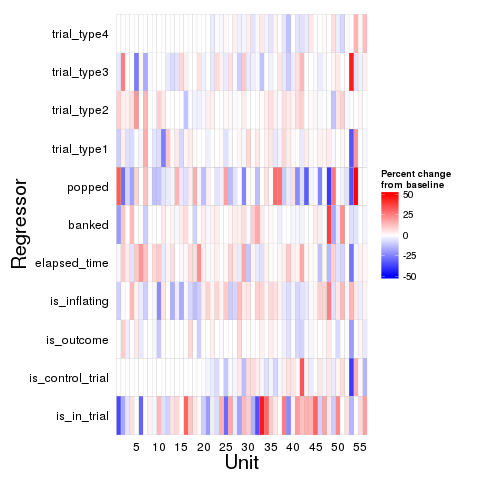

In [26]:
lambdatype = 'none'
%Rpush lambdatype
%R source("analyze_spike_glm_output.R");
%Rpull effects
effects = pd.DataFrame(effects)
effects.columns = ['Unit', 'In trial', 'Control Trial', 'Outcome period', 'Inflating', 'Elapsed time', 'Banked', 
                   'Popped', 'Low Risk', 'Medium Risk', 'High Risk', 'Unrewarded Trial']
effects = effects.set_index('Unit')

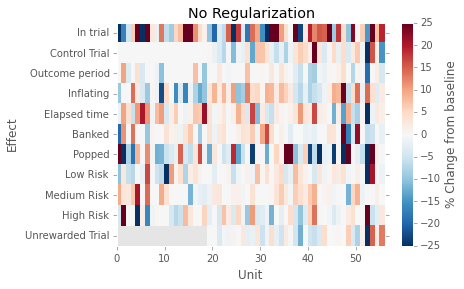

In [27]:
plot_effects(effects, cmap, 'No Regularization')

# Shuffle control

Do the parsimonious regression on shuffled data

In [28]:
!Rscript perform_glm_analysis.R spikes shuffle

[1] "Performing spike analysis..."
[1] "data/10.1.1.1.spkglmdata.csv"
[1] "data/11.1.1.1.spkglmdata.csv"
[1] "data/12.1.1.1.spkglmdata.csv"
[1] "data/14.1.1.1.spkglmdata.csv"
[1] "data/14.2.1.1.spkglmdata.csv"
[1] "data/15.1.1.1.spkglmdata.csv"
[1] "data/17.1.1.1.spkglmdata.csv"
[1] "data/17.2.1.1.spkglmdata.csv"
[1] "data/17.2.2.1.spkglmdata.csv"
[1] "data/17.2.3.1.spkglmdata.csv"
[1] "data/17.2.5.1.spkglmdata.csv"
[1] "data/17.2.7.1.spkglmdata.csv"
[1] "data/17.2.8.1.spkglmdata.csv"
[1] "data/17.2.10.1.spkglmdata.csv"
[1] "data/17.2.11.1.spkglmdata.csv"
[1] "data/18.1.1.1.spkglmdata.csv"
[1] "data/18.1.1.2.spkglmdata.csv"
[1] "data/18.1.13.1.spkglmdata.csv"
[1] "data/18.1.15.1.spkglmdata.csv"
[1] "data/20.1.1.1.spkglmdata.csv"
[1] "data/20.1.1.2.spkglmdata.csv"
[1] "data/20.1.2.1.spkglmdata.csv"
[1] "data/20.1.2.2.spkglmdata.csv"
[1] "data/20.1.3.1.spkglmdata.csv"
[1] "data/20.1.3.2.spkglmdata.csv"
[1] "data/20.1.4.1.spkglmdata.csv"
[1] "data/20.1.4.2.spkglmdata.csv"
[1] "data/20.1.5

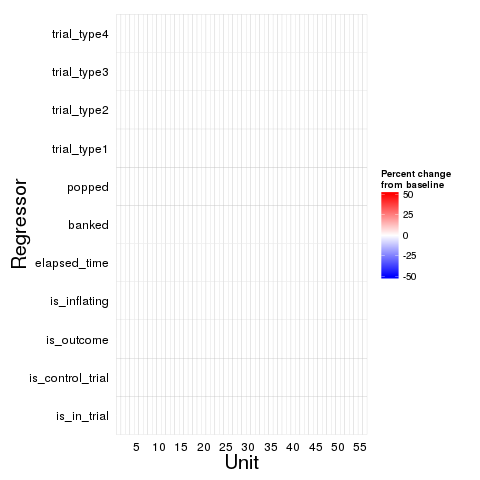

In [29]:
lambdatype = '1se'
%Rpush lambdatype
%R source("analyze_spike_glm_output.R");
%Rpull effects
effects = pd.DataFrame(effects)
effects.columns = ['Unit', 'In trial', 'Control Trial', 'Outcome period', 'Inflating', 'Elapsed time', 'Banked', 
                   'Popped', 'Low Risk', 'Medium Risk', 'High Risk', 'Unrewarded Trial']
effects = effects.set_index('Unit')

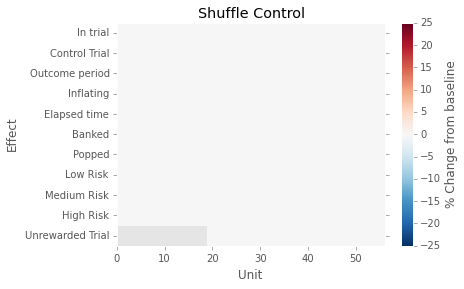

In [30]:
plot_effects(effects, cmap, 'Shuffle Control')